In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [16]:
import logging
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from lib.dataset_utils import *
from lib.mnist_model import *
from lib.adv_model import *
from lib.dknn_attack import DKNNAttack
from lib.cwl2_attack import CWL2Attack
from lib.dknn import DKNN, DKNNL2
from lib.foolbox_model import *
from lib.utils import *

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
exp_id = 0

# model_name = 'train_mnist_exp%d.h5' % exp_id
# net = BasicModel()

# model_name = 'train_mnist_snnl_exp%d.h5' % exp_id
# net = SNNLModel(train_it=True)

# model_name = 'train_mnist_hidden_mixup_exp%d.h5' % exp_id
# net = HiddenMixupModel()

# model_name = 'train_mnist_vae_exp%d.h5' % exp_id
# net = VAE((1, 28, 28), num_classes=10, latent_dim=20)
# net = VAE2((1, 28, 28), num_classes=10, latent_dim=1000)

# model_name = 'train_mnist_cav_exp%d.h5' % exp_id
# net = ClassAuxVAE((1, 28, 28), num_classes=10, latent_dim=20)

model_name = 'adv_mnist_exp%d.h5' % exp_id
basic_net = BasicModel()
# basic_net = BasicModelV2()
config = {'epsilon': 0.3,
              'num_steps': 40,
              'step_size': 0.01,
              'random_start': True,
              'loss_func': 'xent'}
net = PGDModel(basic_net, config)

In [5]:
# Set all random seeds
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set up model directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = net.to(device)
# if device == 'cuda':
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True
net.load_state_dict(torch.load(model_path))
# net = net.module
net = net.basic_net
net.eval()

BasicModel(
  (conv1): Conv2d(1, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace)
  (conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2), padding=(3, 3))
  (relu2): ReLU(inplace)
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU(inplace)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

In [6]:
(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_mnist_all(
    '/data', val_size=0.1, seed=seed)

In [7]:
y_pred = net(x_test.to(device))
(y_pred.argmax(1).cpu() == y_test).sum().numpy() / y_test.size(0)

0.9833

In [8]:
# layers = ['relu1', 'relu2', 'relu3', 'fc']
# layers = ['relu1', 'relu2', 'relu3']
layers = ['relu3']
# layers = ['fc2']
# layers = ['en_conv3']
# layers = ['en_mu']
# layers = ['maxpool1', 'maxpool2', 'relu3', 'fc2']
# layers = ['maxpool2']

# with torch.no_grad():
#     dknn = DKNN(net, x_train, y_train, x_valid, y_valid, layers, 
#                 k=75, num_classes=10)
#     y_pred = dknn.classify(x_test)
    
dknn = DKNNL2(net, x_train, y_train, x_valid, y_valid, layers, 
              k=75, num_classes=10)

In [11]:
with torch.no_grad():
    y_pred = dknn.classify(x_test)
    print((y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0))

0.9653


(array([ 994.,  813.,  695.,  959.,    0.,    0.,    0.,    0.,    0.,
        6539.]),
 array([0.01666667, 0.115     , 0.21333333, 0.31166667, 0.41      ,
        0.50833333, 0.60666667, 0.705     , 0.80333333, 0.90166667,
        1.        ]),
 <a list of 10 Patch objects>)

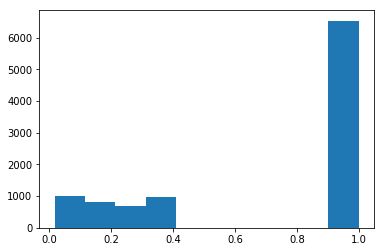

In [12]:
cred = dknn.credibility(y_pred)
plt.hist(cred)

In [13]:
correct = np.argmax(y_pred, 1) == y_test.numpy()
num_correct_by_cred = np.zeros((10, ))
num_cred = np.zeros((10, ))
for i in np.arange(10):
    ind = (cred > i * 0.1) & (cred <= i* 0.1 + 0.1)
    num_cred[i] = np.sum(ind)
    num_correct_by_cred[i] = np.sum(correct[ind])

<BarContainer object of 10 artists>

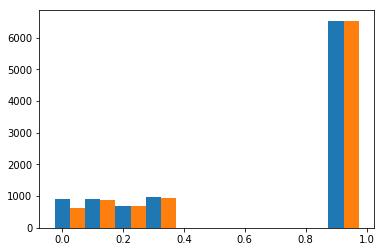

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(10) * 0.1, num_cred, width=0.05)
ax.bar(np.arange(10) * 0.1 + 0.05, num_correct_by_cred, width=0.05)

In [15]:
num_correct_by_cred / num_cred

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([0.6875    , 0.94731065, 0.99136691, 0.99687174,        nan,
              nan,        nan,        nan,        nan, 0.99847071])

In [17]:
dknn_fb = DkNNFoolboxModel(dknn, (0, 1), 1, preprocessing=(0, 1))

In [26]:
from foolbox.criteria import Misclassification
from foolbox.distances import MeanSquaredDistance

criterion = Misclassification()
distance = MeanSquaredDistance

attack = foolbox.attacks.BoundaryAttack(
    model=dknn_fb, criterion=criterion, distance=distance)

In [ ]:
attack_params = {
    'iterations': 10000,
    'max_directions': 25,
    'starting_point': None,
    'initialization_attack': None,
    'log_every_n_steps': 10,
    'spherical_step': 0.01,
    'source_step': 0.01,
    'step_adaptation': 1.5,
    'batch_size': 1,
    'tune_batch_size': True, 
    'threaded_rnd': True, 
    'threaded_gen': True, 
    'alternative_generator': False
}

num = 100
x_adv = np.zeros_like(x_test[:num].numpy())
for i in range(100):
    x_adv[i] = attack(x_test[i].numpy(), label=y_test[i].numpy(), 
                      unpack=True, verbose=True, **attack_params)

Neither starting_point nor initialization_attack given. Falling back to BlendedUniformNoiseAttack for initialization.
Initial spherical_step = 0.01, source_step = 0.01
Using 4 threads to create random numbers
Step 0: 8.25497e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 10: 8.25497e-02, stepsizes = 1.0e-02/1.0e-02:  (took 2.09354 seconds)
Step 20: 8.25497e-02, stepsizes = 1.0e-02/1.0e-02:  (took 2.02172 seconds)
  Success rate too low, decreasing source step:  0.63 ( 75), 0.00 (30)
Step 30: 8.25497e-02, stepsizes = 1.0e-02/6.7e-03:  (took 2.43455 seconds)
  Boundary too linear, increasing steps:     0.60 (100), 0.00 (13)
Step 40: 8.25497e-02, stepsizes = 1.5e-02/1.0e-02:  (took 1.95784 seconds)
Step 50: 8.25497e-02, stepsizes = 1.5e-02/1.0e-02:  (took 2.12790 seconds)
  Success rate too low, decreasing source step:  0.44 ( 50), 0.00 (30)
Step 60: 8.25497e-02, stepsizes = 1.5e-02/6.7e-03:  (took 2.08625 seconds)
Step 70: 8.03703e-02, stepsizes = 1.5e-02/6.7e-03:  (took 1.95560 seconds)
Step 8

  Success rate too low, decreasing source step:  0.41 ( 75), 0.13 (30)
Step 210: 3.98789e-02, stepsizes = 3.4e-02/3.0e-03:  (took 0.34768 seconds)
Step 220: 3.87130e-02, stepsizes = 3.4e-02/3.0e-03: d. reduced by 0.59% (2.3043e-04) (took 0.16391 seconds)
Step 230: 3.64823e-02, stepsizes = 3.4e-02/3.0e-03: d. reduced by 0.59% (2.1716e-04) (took 0.15531 seconds)
Step 240: 3.43802e-02, stepsizes = 3.4e-02/3.0e-03: d. reduced by 0.59% (2.0464e-04) (took 0.20843 seconds)
  Boundary too linear, increasing steps:     0.51 (100), 0.43 (30)
Step 250: 3.23992e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.59% (1.9285e-04) (took 0.20941 seconds)
  Success rate too high, increasing source step: 0.85 ( 20), 0.60 (30)
Step 260: 2.96377e-02, stepsizes = 5.1e-02/6.7e-03: d. reduced by 0.89% (2.6521e-04) (took 0.27081 seconds)
Step 270: 2.62757e-02, stepsizes = 5.1e-02/6.7e-03: d. reduced by 1.33% (3.5388e-04) (took 0.23032 seconds)
Step 280: 2.32951e-02, stepsizes = 5.1e-02/6.7e-03: d. reduced by 1

Step 410: 7.27676e-03, stepsizes = 7.6e-02/4.4e-03: d. reduced by 0.89% (6.5116e-05) (took 0.19676 seconds)
Step 420: 6.71610e-03, stepsizes = 7.6e-02/4.4e-03:  (took 0.35834 seconds)
Step 430: 6.31007e-03, stepsizes = 7.6e-02/4.4e-03:  (took 0.26538 seconds)
Step 440: 5.92859e-03, stepsizes = 7.6e-02/4.4e-03: d. reduced by 0.89% (5.3052e-05) (took 0.19764 seconds)
  Success rate too low, decreasing source step:  0.26 (100), 0.07 (30)
Step 450: 5.57017e-03, stepsizes = 7.6e-02/3.0e-03: d. reduced by 0.89% (4.9845e-05) (took 0.20441 seconds)
Step 460: 5.31189e-03, stepsizes = 7.6e-02/3.0e-03: d. reduced by 0.59% (3.1618e-05) (took 0.19487 seconds)
Step 470: 5.06559e-03, stepsizes = 7.6e-02/3.0e-03: d. reduced by 0.59% (3.0152e-05) (took 0.23648 seconds)
Step 480: 4.85946e-03, stepsizes = 7.6e-02/3.0e-03:  (took 0.24977 seconds)
Step 490: 4.71738e-03, stepsizes = 7.6e-02/3.0e-03:  (took 0.23816 seconds)
Step 500: 4.66172e-03, stepsizes = 7.6e-02/3.0e-03:  (took 0.21587 seconds)
Estimatin

Step 610: 3.72271e-03, stepsizes = 3.4e-02/8.8e-04: d. reduced by 0.18% (6.5451e-06) (took 0.21229 seconds)
  Success rate too high, increasing source step: 0.45 (100), 0.70 (30)
Step 620: 3.66432e-03, stepsizes = 3.4e-02/1.3e-03: d. reduced by 0.18% (6.4424e-06) (took 0.18776 seconds)
Step 630: 3.64506e-03, stepsizes = 3.4e-02/1.3e-03: d. reduced by 0.26% (9.6192e-06) (took 0.17721 seconds)
Step 640: 3.58787e-03, stepsizes = 3.4e-02/1.3e-03: d. reduced by 0.26% (9.4682e-06) (took 0.25095 seconds)
Step 650: 3.53159e-03, stepsizes = 3.4e-02/1.3e-03:  (took 0.19817 seconds)
Step 660: 3.50377e-03, stepsizes = 3.4e-02/1.3e-03:  (took 0.19861 seconds)
  Success rate too low, decreasing source step:  0.28 (100), 0.10 (30)
Step 670: 3.48535e-03, stepsizes = 3.4e-02/8.8e-04: d. reduced by 0.26% (9.1978e-06) (took 0.15432 seconds)
Step 680: 3.44276e-03, stepsizes = 3.4e-02/8.8e-04: d. reduced by 0.18% (6.0529e-06) (took 0.16922 seconds)
  Boundary too non-linear, decreasing steps: 0.15 (100), 0

Step 980: 2.93636e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (1.5283e-06) (took 0.17679 seconds)
Step 990: 2.92568e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (1.5226e-06) (took 0.18668 seconds)
Step 1000: 2.91353e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (1.5163e-06) (took 0.19769 seconds)
Step 1010: 2.90899e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (1.5141e-06) (took 0.18742 seconds)
  Boundary too non-linear, decreasing steps: 0.19 (100), 0.20 (30)
Step 1020: 2.90143e-03, stepsizes = 6.7e-03/1.7e-04: d. reduced by 0.05% (1.5100e-06) (took 0.21976 seconds)
  Success rate too low, decreasing source step:  0.40 ( 25), 0.17 (30)
Step 1030: 2.89439e-03, stepsizes = 6.7e-03/1.2e-04:  (took 0.20240 seconds)
Step 1040: 2.88771e-03, stepsizes = 6.7e-03/1.2e-04: d. reduced by 0.02% (6.6770e-07) (took 0.25303 seconds)
Step 1050: 2.88170e-03, stepsizes = 6.7e-03/1.2e-04: d. reduced by 0.02% (6.6641e-07) (took 0.17978 seconds)
Step 1060: 2.87571e-03, 

Step 1340: 2.71355e-03, stepsizes = 1.0e-02/1.7e-04:  (took 0.18655 seconds)
Step 1350: 2.71073e-03, stepsizes = 1.0e-02/1.7e-04:  (took 0.19043 seconds)
Step 1360: 2.70228e-03, stepsizes = 1.0e-02/1.7e-04: d. reduced by 0.03% (9.3746e-07) (took 0.20458 seconds)
  Success rate too low, decreasing source step:  0.26 (100), 0.17 (30)
Step 1370: 2.69573e-03, stepsizes = 1.0e-02/1.2e-04: d. reduced by 0.03% (9.3517e-07) (took 0.18735 seconds)
Step 1380: 2.68950e-03, stepsizes = 1.0e-02/1.2e-04: d. reduced by 0.02% (6.2200e-07) (took 0.19278 seconds)
Step 1390: 2.68391e-03, stepsizes = 1.0e-02/1.2e-04: d. reduced by 0.02% (6.2062e-07) (took 0.22613 seconds)
  Success rate too high, increasing source step: 0.42 (100), 0.67 (30)
Step 1400: 2.67833e-03, stepsizes = 1.0e-02/1.7e-04: d. reduced by 0.02% (6.1943e-07) (took 0.21417 seconds)
Step 1410: 2.66998e-03, stepsizes = 1.0e-02/1.7e-04: d. reduced by 0.03% (9.2632e-07) (took 0.17173 seconds)
Step 1420: 2.66351e-03, stepsizes = 1.0e-02/1.7e-0

Step 2010: 2.52039e-03, stepsizes = 3.0e-03/2.3e-05: d. reduced by 0.00% (1.1513e-07) (took 0.24375 seconds)
Step 2020: 2.51935e-03, stepsizes = 3.0e-03/2.3e-05: d. reduced by 0.00% (1.1505e-07) (took 0.21995 seconds)
Step 2030: 2.51820e-03, stepsizes = 3.0e-03/2.3e-05: d. reduced by 0.00% (1.1507e-07) (took 0.18664 seconds)
Step 2040: 2.51705e-03, stepsizes = 3.0e-03/2.3e-05: d. reduced by 0.00% (1.1501e-07) (took 0.23882 seconds)
  Success rate too high, increasing source step: 0.42 (100), 0.60 (30)
Step 2050: 2.51625e-03, stepsizes = 3.0e-03/3.4e-05: d. reduced by 0.00% (1.1485e-07) (took 0.17324 seconds)
Step 2060: 2.51487e-03, stepsizes = 3.0e-03/3.4e-05:  (took 0.14292 seconds)
Step 2070: 2.51349e-03, stepsizes = 3.0e-03/3.4e-05: d. reduced by 0.01% (1.7221e-07) (took 0.21078 seconds)
Step 2080: 2.51228e-03, stepsizes = 3.0e-03/3.4e-05: d. reduced by 0.01% (1.7209e-07) (took 0.22511 seconds)
Step 2090: 2.51142e-03, stepsizes = 3.0e-03/3.4e-05: d. reduced by 0.01% (1.7209e-07) (to

Step 2760: 2.47571e-03, stepsizes = 5.9e-04/4.5e-06: d. reduced by 0.00% (2.2307e-08) (took 0.24498 seconds)
Step 2770: 2.47549e-03, stepsizes = 5.9e-04/4.5e-06: d. reduced by 0.00% (2.2325e-08) (took 0.19677 seconds)
  Boundary too linear, increasing steps:     0.51 (100), 0.57 (30)
  Success rate too high, increasing source step: 0.51 (100), 0.57 (30)
Step 2780: 2.47527e-03, stepsizes = 8.8e-04/1.0e-05: d. reduced by 0.00% (2.2339e-08) (took 0.25286 seconds)
Step 2790: 2.47507e-03, stepsizes = 8.8e-04/1.0e-05:  (took 0.19883 seconds)
Step 2800: 2.47486e-03, stepsizes = 8.8e-04/1.0e-05: d. reduced by 0.00% (5.0243e-08) (took 0.15519 seconds)
Step 2810: 2.47461e-03, stepsizes = 8.8e-04/1.0e-05: d. reduced by 0.00% (5.0226e-08) (took 0.18307 seconds)
  Boundary too non-linear, decreasing steps: 0.17 (100), 0.12 (17)
Step 2820: 2.47441e-03, stepsizes = 5.9e-04/6.8e-06:  (took 0.21205 seconds)
Step 2830: 2.47435e-03, stepsizes = 5.9e-04/6.8e-06:  (took 0.18248 seconds)
  Success rate too 

Step 3470: 2.46666e-03, stepsizes = 7.7e-05/8.9e-07:  (took 0.17363 seconds)
  Success rate too low, decreasing source step:  0.25 (100), 0.13 (30)
Step 3480: 2.46665e-03, stepsizes = 7.7e-05/5.9e-07:  (took 0.22854 seconds)
  Boundary too non-linear, decreasing steps: 0.17 (100), 0.20 ( 5)
Step 3490: 2.46662e-03, stepsizes = 5.1e-05/4.0e-07: d. reduced by 0.00% (2.9238e-09) (took 0.16063 seconds)
Step 3500: 2.46661e-03, stepsizes = 5.1e-05/4.0e-07: d. reduced by 0.00% (1.9834e-09) (took 0.15173 seconds)
Step 3510: 2.46659e-03, stepsizes = 5.1e-05/4.0e-07: d. reduced by 0.00% (1.9324e-09) (took 0.25503 seconds)
  Success rate too high, increasing source step: 0.35 ( 75), 0.57 (30)
Step 3520: 2.46658e-03, stepsizes = 5.1e-05/5.9e-07: d. reduced by 0.00% (2.0390e-09) (took 0.17533 seconds)
Step 3530: 2.46656e-03, stepsizes = 5.1e-05/5.9e-07:  (took 0.28606 seconds)
Step 3540: 2.46654e-03, stepsizes = 5.1e-05/5.9e-07:  (took 0.12067 seconds)
  Boundary too non-linear, decreasing steps: 0.

  Boundary too non-linear, decreasing steps: 0.08 (100), 0.00 (12)
  Boundary too non-linear, decreasing steps: 0.01 (100), 0.00 (13)
Step 3750: 2.46646e-03, stepsizes = 1.0e-05/4.5e-06:  (took 0.12884 seconds)
  Boundary too non-linear, decreasing steps: 0.00 (100), 0.00 (13)
  Boundary too non-linear, decreasing steps: 0.01 (100), 0.00 (14)
  Boundary too non-linear, decreasing steps: 0.03 (100), 0.00 (17)
Step 3760: 2.46646e-03, stepsizes = 3.0e-06/1.3e-06:  (took 0.17708 seconds)
  Boundary too non-linear, decreasing steps: 0.01 (100), 0.00 (18)
  Boundary too non-linear, decreasing steps: 0.02 (100), 0.00 (20)
Step 3770: 2.46646e-03, stepsizes = 1.3e-06/5.9e-07:  (took 0.18726 seconds)
  Boundary too non-linear, decreasing steps: 0.02 (100), 0.00 (22)
  Boundary too non-linear, decreasing steps: 0.01 (100), 0.00 (23)
  Boundary too non-linear, decreasing steps: 0.01 (100), 0.00 (24)
Step 3780: 2.46646e-03, stepsizes = 4.0e-07/1.8e-07:  (took 0.11583 seconds)
  Boundary too non-lin

Step 3837: 2.46646e-03, stepsizes = 7.8e-08/2.7e-10: 
Looks like attack has converged after 3838 steps, 51 remaining
Step 3838: 2.46646e-03, stepsizes = 7.8e-08/2.7e-10: 
Looks like attack has converged after 3839 steps, 50 remaining
Step 3839: 2.46646e-03, stepsizes = 7.8e-08/2.7e-10: 
Looks like attack has converged after 3840 steps, 49 remaining
Step 3840: 2.46646e-03, stepsizes = 7.8e-08/2.7e-10:  (took 0.21304 seconds)
Step 3840: 2.46646e-03, stepsizes = 7.8e-08/2.7e-10: 
Looks like attack has converged after 3841 steps, 48 remaining
  Success rate too low, decreasing source step:  0.39 (100), 0.00 (30)
Step 3841: 2.46646e-03, stepsizes = 7.8e-08/1.8e-10: 
Looks like attack has converged after 3842 steps, 47 remaining
Step 3842: 2.46646e-03, stepsizes = 7.8e-08/1.8e-10: 
Looks like attack has converged after 3843 steps, 46 remaining
Step 3843: 2.46646e-03, stepsizes = 7.8e-08/1.8e-10: 
Looks like attack has converged after 3844 steps, 45 remaining
Step 3844: 2.46646e-03, stepsizes

Step 60: 7.46753e-02, stepsizes = 1.5e-02/6.7e-03:  (took 2.44190 seconds)
Step 70: 7.36830e-02, stepsizes = 1.5e-02/6.7e-03:  (took 3.04779 seconds)
  Boundary too linear, increasing steps:     0.53 (100), 0.00 (30)
  Success rate too low, decreasing source step:  0.53 (100), 0.00 (30)
Step 80: 7.36830e-02, stepsizes = 2.2e-02/6.7e-03:  (took 3.19784 seconds)
Step 90: 7.27038e-02, stepsizes = 2.2e-02/6.7e-03:  (took 3.24510 seconds)
Step 100: 6.62045e-02, stepsizes = 2.2e-02/6.7e-03: d. reduced by 1.33% (8.9163e-04) (took 1.17970 seconds)
Initializing generation and prediction time measurements. This can take a few seconds.
During initialization, a better adversarial has been found. Continuing from there.
Estimating optimal batch size
Time since beginning: 290.45166
   1.3% for generation (3.65606)
   17.3% for spherical prediction (50.37973)
   69.0% for prediction (200.34252)
   0.0% for hyperparameter update (0.01289)
   12.4% for the rest (36.06046)
current estimate of the time to

Step 210: 2.55107e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (2.2828e-04) (took 0.66690 seconds)
  Boundary too linear, increasing steps:     0.60 (100), 0.83 (30)
  Success rate too high, increasing source step: 0.60 (100), 0.83 (30)
Step 220: 2.33363e-02, stepsizes = 7.6e-02/1.0e-02: d. reduced by 0.89% (2.0883e-04) (took 0.70257 seconds)
Step 230: 2.11050e-02, stepsizes = 7.6e-02/1.0e-02: d. reduced by 1.99% (4.2852e-04) (took 0.52678 seconds)
Step 240: 2.11050e-02, stepsizes = 7.6e-02/1.0e-02:  (took 0.72237 seconds)
Step 250: 1.90870e-02, stepsizes = 7.6e-02/1.0e-02: d. reduced by 1.99% (3.8754e-04) (took 0.61468 seconds)
Step 260: 1.72619e-02, stepsizes = 7.6e-02/1.0e-02: d. reduced by 1.99% (3.5049e-04) (took 0.32114 seconds)
Step 270: 1.53007e-02, stepsizes = 7.6e-02/1.0e-02: d. reduced by 1.99% (3.1067e-04) (took 0.48316 seconds)
  Success rate too low, decreasing source step:  0.42 (100), 0.17 (30)
Step 280: 1.49962e-02, stepsizes = 7.6e-02/6.7e-03:  (took 0.69984 

In [54]:
y_pred = dknn.classify(torch.tensor(x_adv))
print((y_pred.argmax(1) == y_test[:num].numpy()).sum() / num)

0.31


In [55]:
dist = np.sqrt(np.sum((x_adv - x_test[:num].numpy())**2, (1, 2, 3)))
print(dist.mean())

1.7054516


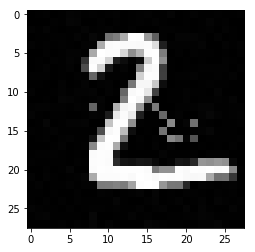

In [60]:
plt.imshow(x_adv[1].reshape(28, 28), cmap='gray')

In [44]:
np.sqrt(np.sum((x_adv - x_test[:100].numpy())**2))

5.0946236

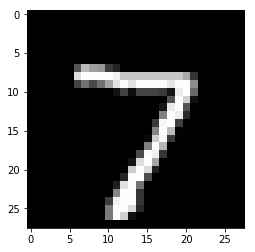

In [57]:
plt.imshow(x_test[0].numpy().reshape(28, 28), cmap='gray')

In [61]:
pickle.dump(x_adv, open('x_adv_boundary_adv0.p', 'wb'))

In [90]:
i = 0
j = 0
st = ['AAATTTCCCCCC','CCCAAATTCTTC','TTCTTATTGTTG','TTGTTATTGTTG']

while j < len(st):

    if st[i][0:3] == st[j][-3:]:
        st[i] = st[j][0:-3] + st[i]
        st = np.delete(st, j)
    elif st[j][0:3] == st[i][-3:]:
        print(st)
        print(st[i])
        print(st[j][3:])
        print(st[i] + st[j][3:])
        st[i] = st[i] + st[j][3:]
        print(st[i])
        st.pop(j)
        print(st)
    else:
        j = j + 1

['AAATTTCCCCCC', 'CCCAAATTCTTC', 'TTCTTATTGTTG', 'TTGTTATTGTTG']
AAATTTCCCCCC
AAATTCTTC
AAATTTCCCCCCAAATTCTTC
AAATTTCCCCCCAAATTCTTC
['AAATTTCCCCCCAAATTCTTC', 'TTCTTATTGTTG', 'TTGTTATTGTTG']
['AAATTTCCCCCCAAATTCTTC', 'TTCTTATTGTTG', 'TTGTTATTGTTG']
AAATTTCCCCCCAAATTCTTC
TTATTGTTG
AAATTTCCCCCCAAATTCTTCTTATTGTTG
AAATTTCCCCCCAAATTCTTCTTATTGTTG
['AAATTTCCCCCCAAATTCTTCTTATTGTTG', 'TTGTTATTGTTG']
['AAATTTCCCCCCAAATTCTTCTTATTGTTG', 'TTGTTATTGTTG']
AAATTTCCCCCCAAATTCTTCTTATTGTTG
TTATTGTTG
AAATTTCCCCCCAAATTCTTCTTATTGTTGTTATTGTTG
AAATTTCCCCCCAAATTCTTCTTATTGTTGTTATTGTTG
['AAATTTCCCCCCAAATTCTTCTTATTGTTGTTATTGTTG']


In [70]:
st

array(['AAATTTCCCCCC', 'TTCTTATTGTTG', 'TTGTTATTGTTG'], dtype='<U12')

In [85]:
st = np.array(['AAATTTCCCCCC','CCCAAATTCTTC','TTCTTATTGTTG','TTGTTATTGTTG'])

In [86]:
st[0] = st[0] + st[1]

In [87]:
st

array(['AAATTTCCCCCC', 'CCCAAATTCTTC', 'TTCTTATTGTTG', 'TTGTTATTGTTG'],
      dtype='<U12')